# Libraries and function

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import pandas as pd
import pyBigWig as bw
import os
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import sys
sys.path.insert(0, '/home/jbreda/PROseq/scripts/Phase_to_LabColor')
from phase_to_labcolor import phase_to_labcolor as p2lc
sys.path.insert(0, '/home/jbreda/PROseq/scripts/FourierTransform')
from fourier_transform import fourier_transform

import threading
print(threading.active_count(), 'threads active at start')

from multiprocessing import Pool

import h5py

from KalmanFilter import KalmanFilter, KalmanFilter_k_hidden

def get_gtf(infile):

    # Read gtf file
    gtf = pd.read_csv(infile,sep='\t',header=None)
    gtf.columns = ['chr','source','type','start','end','score','strand','frame','attribute']
    gtf['gene_name'] = gtf.attribute.str.extract(r'gene_name "(.*?)";')
    N_gene = gtf.shape[0]

    # fix gene duplicates
    dup = gtf.gene_name.value_counts()
    my_genes = dup[dup>1].index
    for g in my_genes:
        idx = gtf[gtf.gene_name==g].index
        same_chr = (gtf.loc[idx,['chr','strand']].nunique().values == 1).all()
        overlap =  gtf.loc[idx,'end'].max() - gtf.loc[idx,'start'].min() < (gtf.loc[idx,'end'].values - gtf.loc[idx,'start'].values).sum()*2
        #gtf.loc[idx,['start']].values.max() < gtf.loc[idx,['end']].values.min()
        if same_chr and overlap:

            gtf.loc[idx[0],'start'] = gtf.loc[idx,'start'].min()
            gtf.loc[idx[0],'end'] = gtf.loc[idx,'end'].max()
            gtf.drop(idx[1:],inplace=True)
            
        else:
            print(g)
            gtf.loc[idx,'gene_name'] = [f'{g}_{i}' for i in range(len(idx))]
    gtf.set_index('gene_name',inplace=True,drop=True)

    return gtf

def get_data(coord, bw_folder, bin_size,fill_empty_bin=True):

    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')
    start = int(start)
    end = int(end)

    # Load bigWigs to dataframe
    df = pd.DataFrame(columns=['start','end'])
    for t in T:
        sample = f'CT{t:02d}'
        fin = f"{bw_folder}/{sample}/NormCoverage_3p_{strand_dict[strand]}_bin{bin_size}bp.bw"
        with bw.open(fin,'r') as bw_file:
            df_t = pd.DataFrame(bw_file.intervals(chr,start,end),columns=['start','end',f"{t}"])
        df = pd.merge(df,df_t,on=['start','end'],how='outer')
    df.sort_values('start',inplace=True)
    df.reset_index(inplace=True,drop=True)

    # replace start and end with position in the middle of the bin, and set as index
    df['start'] = ( df.start.values + bin_size/2 ).astype(int) # bp
    df.rename(columns={'start':'pos'},inplace=True)
    df.drop('end',axis=1,inplace=True)
    df.set_index('pos',inplace=True)

    # fill empty bins with 0
    if fill_empty_bin:
        start_bin = start//bin_size*bin_size + int(bin_size/2)
        end_bin = int(np.ceil(end/bin_size)*bin_size) - int(bin_size/2)
        x = np.arange(start_bin, end_bin+1, bin_size)
        positions = df.index.values
        missing_pos = np.setdiff1d(x,positions)
        missing = pd.DataFrame(np.zeros((missing_pos.shape[0],df.shape[1])),index=missing_pos,columns=df.columns)
        df = pd.concat([df,missing],axis=0)
        df.sort_index(inplace=True)
        
    df.fillna(0,inplace=True)
    df = df.apply(lambda x: np.log2(x+1),axis=1)

    return df




7 threads active at start


# Get data

In [3]:
bin_size = 1000 # bin size
genome = 'GRCm38'

T = np.arange(0,48,4) # time points [h]
P = 24 # period [h]
ω = 2*np.pi/P # angular frequency [rad/h]
m = len(T) # number of time points
dx = bin_size # distance between positions [bp]

# observation model: inverse fourier transform
#H = np.zeros((m,n))
#H[:,0] = np.cos(ω*T)
#H[:,1] = -np.sin(ω*T)
#H /= 6

# get overall phase and amplitude
#df_overall = pd.read_csv(f'../results/phase_amp/overall_phase_amp_1000bp.csv',index_col=0,sep='\t')
#r_genome = df_overall.amplitude.values
#φ_genome = df_overall.phase.values
#a_genome = r_genome * np.cos(φ_genome)
#b_genome = r_genome * np.sin(φ_genome)
#μ_genome = a_genome + 1j*b_genome
#
#del df_overall, r_genome, φ_genome, a_genome, b_genome

# get gene phase and amplitude perbin for each gene
bw_folder = f'../results/{genome}/binned_norm_coverage'
file_gene_phase = f'../results/{genome}/phase_amp/gene_phase_amp.csv'
gene_phase_amp = pd.read_csv(file_gene_phase,index_col=-1,sep='\t')

#infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-3/Kalman_Smoothing_{bin_size}bp.hdf5'
infile_kalman_on_genes = f'../results/{genome}/kalman/Gene_Q_1e-5/Kalman_Smoothing_{bin_size}bp.hdf5'
#infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-5/Kalman_Smoothing_{bin_size}bp_bu_101_k_bins.hdf5'
with h5py.File(infile_kalman_on_genes, 'r') as hf:
    K = hf['K'][:]

    Genes = list(hf.keys())
    Genes.remove('K')
    Genes = np.array(Genes)
    LL = np.zeros((len(K),len(Genes)))
    adjR2 = np.zeros([len(Genes),2])
    strand = np.zeros(len(Genes),dtype=int)
    for g, gene in enumerate(Genes):
        LL[:,g] = hf[gene]['LL'][:]
        #X = hf[gene]['measurements'][:]
        #smoothed = hf[gene]['smoothed'][:]
        adjR2[g,0] = hf[gene].attrs['adjR2_fourier']
        adjR2[g,1] = hf[gene].attrs['adjR2_kf']
        strand[g] = (1 if hf[gene].attrs['strand'] == '+' else -1)

# get dataframe
df = gene_phase_amp.copy()
df = df.loc[Genes,:]
df['Length'] = df.end - df.start
df['K_max'] = K[np.argmax(LL,axis=0)]
df['speed_max'] = -(ω/3600)/( df['K_max'] )
df['lambda_max_kb'] = (2*np.pi/df.K_max)*1e-3
df['LL_ratio'] = (LL.max(axis=0,keepdims=True) - LL[K==0,:])[0,:]/np.log(2)
df['LL_max'] = LL.max(axis=0)
df['adjR2_f'] = adjR2[:,0]
df['adjR2_kf'] = adjR2[:,1]
n = 12
p = 3
df['adjR2'] = 1 - (1 - df.R2.values)*(n-1)/(n-p-1)
df['strand'] = strand

# flip LL for reverse genes
for g in df.index[df.strand==-1]:
    LL[:,df.index==g] = LL[::-1,df.index==g]

# Take log10 of some columns and rename
df.pval = np.log10(df.pval)
df.Length = np.log10(df.Length)
df.mean_count_per_bp = np.log10(df.mean_count_per_bp)
df.rename(columns={'Length':'log10 Length','mean_count_per_bp':'log10 mean_count_per_bp','pval':'log10 pval'},inplace=True)



ENSMUSG00000026077.15 1811


/tmp/ipykernel_3138448/3748411165.py:23: RuntimeWarning: divide by zero encountered in divide
  V = (ω/3600)/K


Text(0.5, 1.0, 'v_mean = -223.63 bp/s, v_max = -84.53 bp/s')

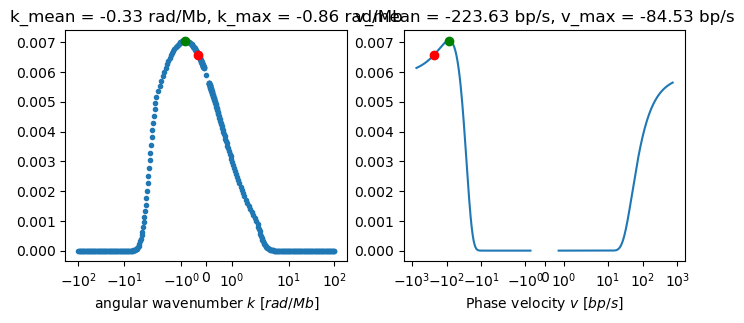

In [4]:
my_gene = 'Npas2'

gene_id = df[df.gene_name == my_gene].index[0]
idx = np.where(df.gene_name == my_gene)[0][0]
print(gene_id, idx)

LL[:,idx]
p = np.exp(LL[:,idx]-LL[:,idx].max())
p /= p.sum()

k_mean = (K*p).sum()
k_max = K[np.argmax(p)]

fig, axes = plt.subplots(1,2,figsize=(8,3))
ax = axes[0]
ax.plot(K*1e6,p,'.')
ax.plot(k_mean*1e6,p[np.argmin(np.abs(K-k_mean))],'ro')
ax.plot(k_max*1e6,p[np.argmin(np.abs(K-k_max))],'go')
ax.set_xscale('symlog')
ax.set_xlabel(r'angular wavenumber $k~[rad/Mb]$')
ax.set_title(f'k_mean = {k_mean*1e6:.2f} rad/Mb, k_max = {k_max*1e6:.2f} rad/Mb')

V = (ω/3600)/K
v_mean = (ω/3600)/k_mean
v_max = (ω/3600)/k_max

ax = axes[1]
ax.plot(V,p)
ax.plot(v_mean,p[np.argmin(np.abs(V-v_mean))],'ro')
ax.plot(v_max,p[np.argmin(np.abs(V-v_max))],'go')
ax.set_xscale('symlog')
ax.set_xlabel(r'Phase velocity $v~[bp/s]$')
ax.set_title(f'v_mean = {v_mean:.2f} bp/s, v_max = {v_max:.2f} bp/s')


Text(0, 0.5, 'adjR2 kalman filter per bin')

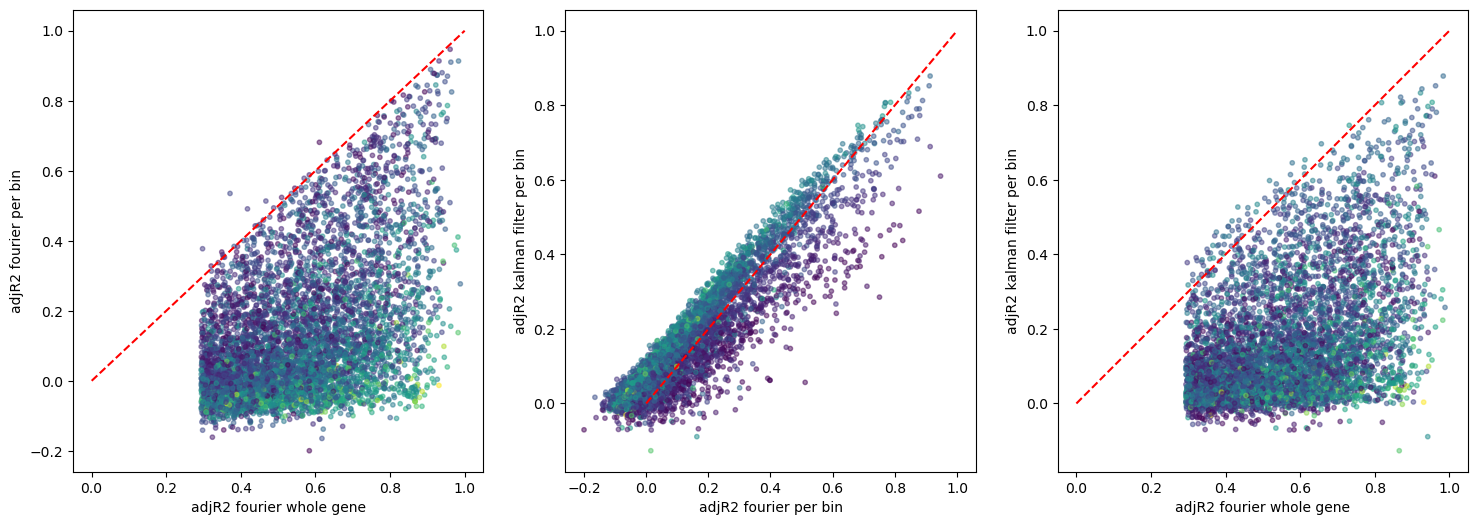

In [85]:
fig, axes = plt.subplots(1,3,figsize=(18,6))



ax = axes[0]
ax.scatter(df.adjR2,df.adjR2_f,s=10,c=df['log10 Length'],alpha=0.5)
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('adjR2 fourier whole gene')
ax.set_ylabel('adjR2 fourier per bin')

ax = axes[1]
ax.scatter(df.adjR2_f,df.adjR2_kf,s=10,c=df['log10 Length'], alpha=0.5)
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('adjR2 fourier per bin')
ax.set_ylabel('adjR2 kalman filter per bin')

ax = axes[2]
ax.scatter(df.adjR2,df.adjR2_kf,s=10,c=df['log10 Length'], alpha=0.5)
ax.plot([0,1],[0,1],'r--')
ax.set_xlabel('adjR2 fourier whole gene')
ax.set_ylabel('adjR2 kalman filter per bin')


# Scatter Plot Kalman smoothing

/tmp/ipykernel_19736/3853966420.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_19736/3853966420.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)
/tmp/ipykernel_19736/3853966420.py:170: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticklabels)


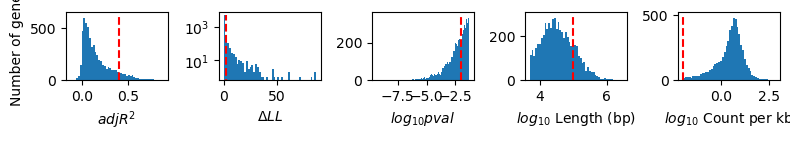

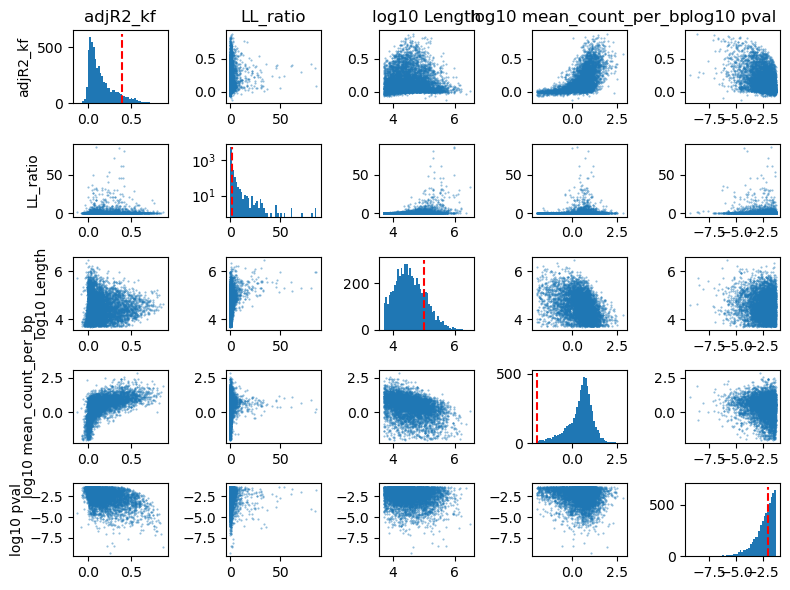

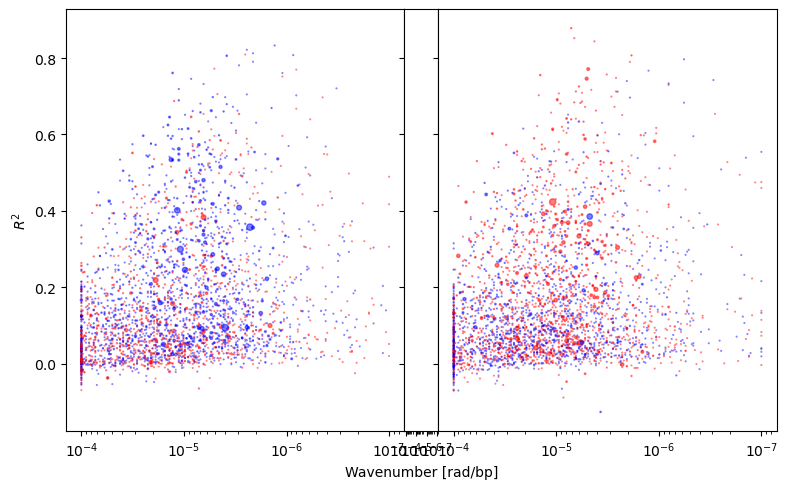

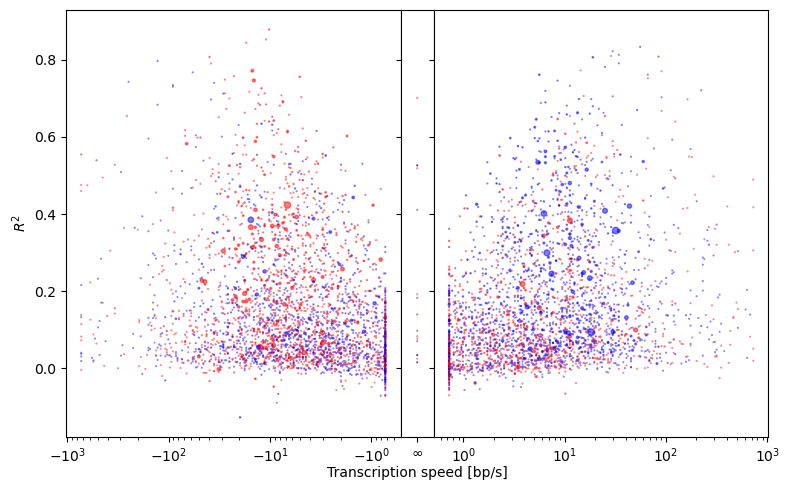

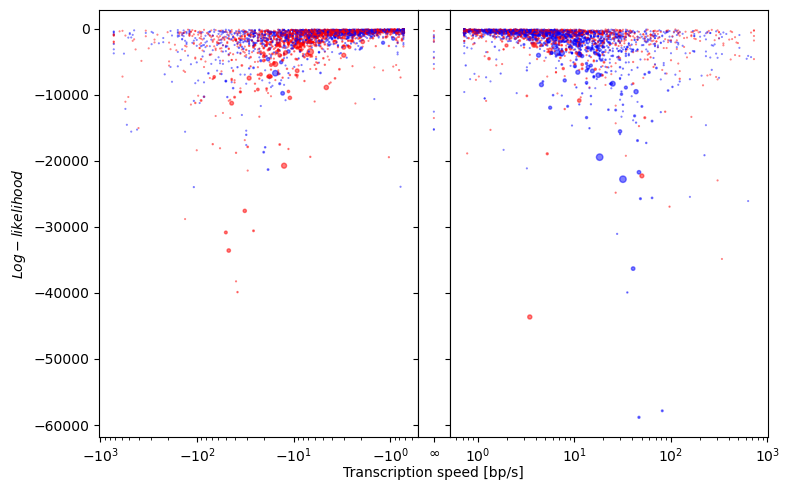

In [85]:
th = {}
th['adjR2_kf'] = 0.4
th['LL_ratio'] = 2
th['log10 Length'] = np.log10(1e5)
th['log10 mean_count_per_bp'] = -2
th['log10 pval'] = -2

# plot distribution of R2, LL_ratio, log10 Length, log10 mean_count_per_bp, log10 pval
fig, axes = plt.subplots(1, 5, figsize=(8, 1.5))
ax = axes[0]
ax.hist(df['adjR2_kf'],bins=50)
ax.plot([th['adjR2_kf'],th['adjR2_kf']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$adjR^2$')
ax.set_ylabel('Number of genes')
ax = axes[1]
ax.hist(df['LL_ratio'],bins=50)
ax.plot([th['LL_ratio'],th['LL_ratio']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$\Delta LL$')
ax.set_yscale('log')
ax = axes[2]
ax.hist(df['log10 pval'],bins=101)
ax.plot([th['log10 pval'],th['log10 pval']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$log_{10} pval$')
ax = axes[3]
ax.hist(df['log10 Length'],bins=50)
ax.set_xlabel(r'$log_{10}$ Length (bp)')
ax.plot([th['log10 Length'],th['log10 Length']],[0,ax.get_ylim()[1]],'r--')
ax = axes[4]
ax.hist(df['log10 mean_count_per_bp'][~np.isinf(df['log10 mean_count_per_bp'])],bins=50)
ax.plot([th['log10 mean_count_per_bp'],th['log10 mean_count_per_bp']],[0,ax.get_ylim()[1]],'r--')
ax.set_xlabel(r'$log_{10}$ Count per kb')


fig.tight_layout()
fig.savefig('fig/kalman/Histogram_R2_LLratio_pval_Len_Count.pdf',bbox_inches='tight')

# scatter plot with every pair of variables
fig, axes = plt.subplots(5, 5, figsize=(8,6))
for i, var1 in enumerate(['adjR2_kf','LL_ratio','log10 Length','log10 mean_count_per_bp','log10 pval']):
    for j, var2 in enumerate(['adjR2_kf','LL_ratio','log10 Length','log10 mean_count_per_bp','log10 pval']):
        ax = axes[i,j]
        if i==j:
            if var1 == 'log10 mean_count_per_bp':
                ax.hist(df[var1][~np.isinf(df[var1])],bins=50)
            else:
                ax.hist(df[var1],bins=50)
            ax.plot([th[var1],th[var1]],[0,ax.get_ylim()[1]],'r--')
            if var1 == 'LL_ratio':
                ax.set_yscale('log')
        else:
            ax.scatter(df[var2],df[var1],marker='.',s=1,alpha=.5)
        
        if i==(len(var1)-1):
            ax.set_xlabel(var2)
        if i == 0:
            ax.set_title(var2)
        if j==0:
            ax.set_ylabel(var1)
fig.tight_layout()
            


# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True,sharex=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8, 5))

# plot
sign = np.sign(df.K_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.K_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'K_max']
        
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
        ax.invert_xaxis()
    elif k_sign == 0:
        x = df.loc[idx,'K_max']
        ax.set_xlabel('Wavenumber [rad/bp]')
        ax.set_xticks([0],['0'])
    elif k_sign == 1:
        x = df.loc[idx,'K_max']
        ax.set_xscale('log')

    #ax.scatter(x=x,y=df.loc[idx,'adjR2_kf'],marker='.',s=10*-np.log10(df.loc[idx,'pval'])+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    ax.scatter(x=x,y=df.loc[idx,'adjR2_kf'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Kmax_R2_LLratio_strand.pdf',bbox_inches='tight')



# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,5))

# plot
sign = np.sign(df.speed_max)
sign[np.isinf(df.speed_max)] = 0
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.speed_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'speed_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = np.sum(sign==0)*[0]
        ax.set_xlim(-1,1)
        ax.set_xticks([0],[r'$\infty$'])
        ax.set_xlabel('Transcription speed [bp/s]')
        idx = np.isinf(df.speed_max)
    elif k_sign == 1:
        x = df.loc[idx,'speed_max']
        ax.set_xscale('log')

    ax.scatter(x=x,y=df.loc[idx,'adjR2_kf'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_speedmax_R2_LLratio_strand.pdf',bbox_inches='tight')


# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1, 3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,5))

# plot
sign = np.sign(df.speed_max)
sign[np.isinf(df.speed_max)] = 0
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df.speed_max) == k_sign)
    if k_sign == -1:
        x = -df.loc[idx,'speed_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$Log-likelihood$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = np.sum(sign==0)*[0]
        ax.set_xlim(-1,1)
        ax.set_xticks([0],[r'$\infty$'])
        ax.set_xlabel('Transcription speed [bp/s]')
        idx = np.isinf(df.speed_max)
    elif k_sign == 1:
        x = df.loc[idx,'speed_max']
        ax.set_xscale('log')

    ax.scatter(x=x,y=df.loc[idx,'LL_max'],marker='.',s=df.loc[idx,'LL_ratio']+1,c=df.loc[idx,'strand'],cmap='bwr_r',alpha=.5)
    
    if k_sign==-1:
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_speedmax_LLmax_LLratio_strand.pdf',bbox_inches='tight')

2972


/home/jbreda/miniforge3/envs/pro-seq/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/jbreda/miniforge3/envs/pro-seq/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


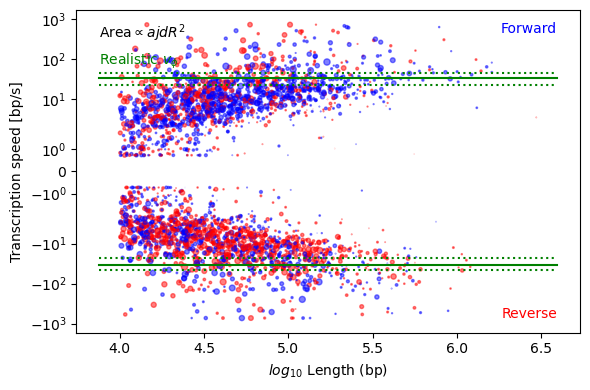

In [88]:
# Thresholds
th = {}
th['adjR2_kf'] = -1
th['log10 Length'] = np.log10(1e4)
th['log10 mean_count_per_bp'] = -2
th['log10 pval'] = -2
idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])

print(idx_top.sum())

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.scatter(x=df.loc[idx_top,'log10 Length'],y=df.loc[idx_top,'speed_max'],s=100*(df.loc[idx_top,'adjR2_kf']),c=df.loc[idx_top,'strand'],cmap='bwr_r',marker='.',alpha=.5)
ax.set_yscale('symlog')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([xlim[0],xlim[1]],[34-11,34-11],'g:')
ax.plot([xlim[0],xlim[1]],[34,34],'g-')
ax.plot([xlim[0],xlim[1]],[34+11,34+11],'g:')
ax.plot([xlim[0],xlim[1]],[-34+11,-34+11],'g:')
ax.plot([xlim[0],xlim[1]],[-34,-34],'g-')
ax.plot([xlim[0],xlim[1]],[-34-11,-34-11],'g:')
ax.set_xlabel(r'$log_{10}$ Length (bp)')
ax.set_ylabel('Transcription speed [bp/s]')

ax.text(xlim[1], .5*ylim[1], 'Forward', fontsize=10, color='b', horizontalalignment='right', verticalalignment='top')
ax.text(xlim[1], .5*ylim[0], 'Reverse', fontsize=10, color='r', horizontalalignment='right', verticalalignment='bottom')
ax.text(xlim[0], .5*ylim[1], r'Area$\propto ajd R^2$', fontsize=10, color='k', horizontalalignment='left', verticalalignment='top')
ax.text(xlim[0], 50, r'Realistic $v_\phi$', fontsize=10, color='g', horizontalalignment='left', verticalalignment='bottom')

fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Length_speedmax_LLmax_strand.pdf',bbox_inches='tight')


266


/tmp/ipykernel_47760/1820331316.py:14: RuntimeWarning: invalid value encountered in divide
  p = np.exp(likelihood)/np.exp(likelihood).sum(axis=0,keepdims=True)
/tmp/ipykernel_47760/1820331316.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i],df_top.loc[g,'adjR2_kf'],df_top.loc[g,'gene_name'],fontsize=8,ha='center',va='bottom')
/tmp/ipykernel_47760/1820331316.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i],df_top.loc[g,'adjR2_kf'],df_top.loc[g,'gene_name'],fontsize=8,ha='center',va='bottom')
/tmp/ipykernel_47760/1820331316.py:79: UserWarning: set_ticklabels() should only be used with

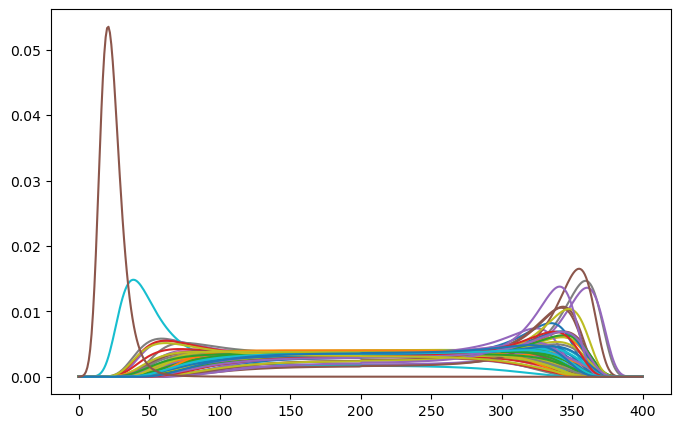

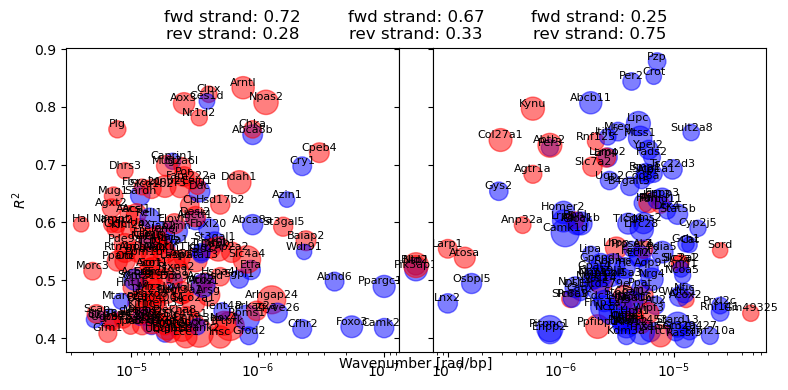

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
/home/jbreda/miniforge3/envs/pro-seq/lib/python3.10/site-packages/matplotlib/transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


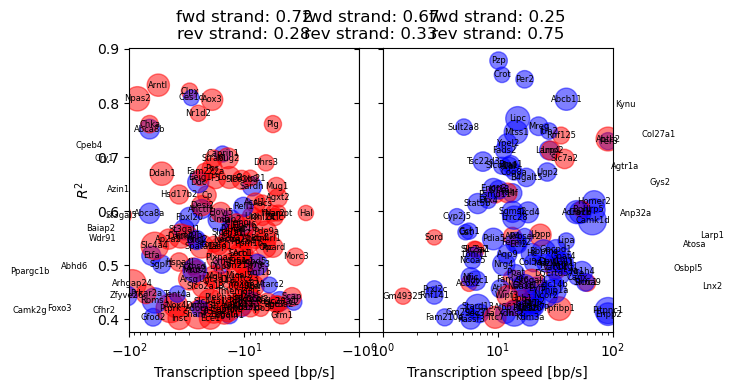

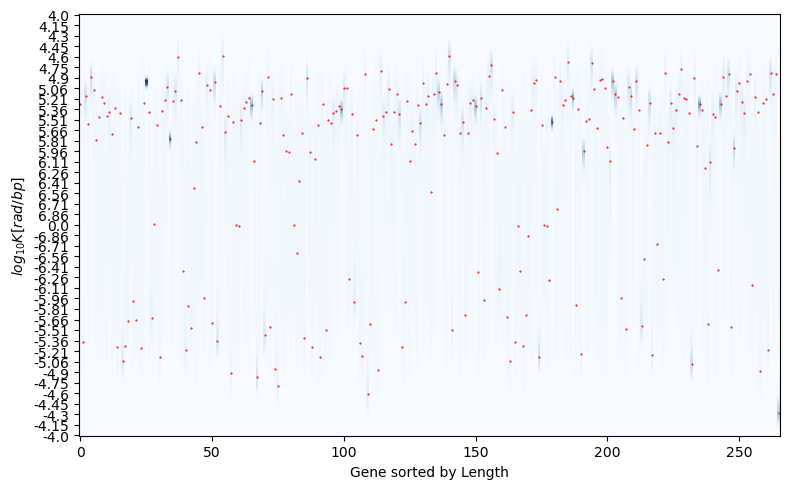

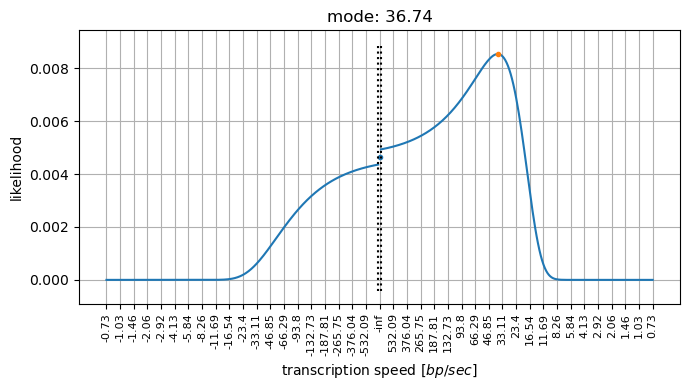

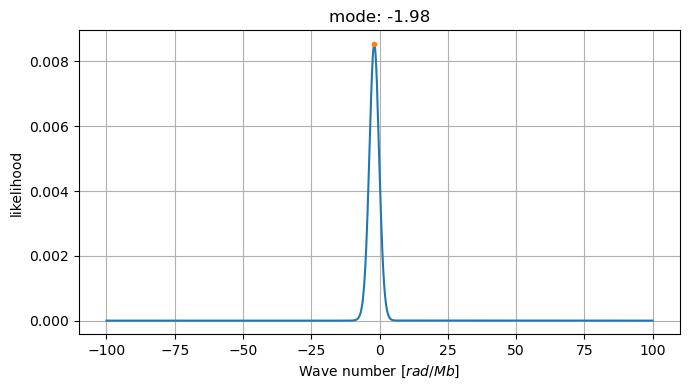

In [96]:
# Thresholds
th = {}
th['adjR2_kf'] = 0.4
th['log10 Length'] = np.log10(3e4)
th['log10 mean_count_per_bp'] = -1
th['log10 pval'] = -2

idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])

print(idx_top.sum())
df_top = df.loc[idx_top,:]

likelihood = LL[:,idx_top]
p = np.exp(likelihood)/np.exp(likelihood).sum(axis=0,keepdims=True)
K_low = K[np.argmin( np.abs(np.cumsum(p,0)-0.05), axis=0)]
K_high = K[np.argmin( np.abs(np.cumsum(p,0)-0.95), axis=0)]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(K.shape[0]),p)

# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1,3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,4))

# plot
sign = np.sign(df_top.K_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df_top.K_max) == k_sign)
    f_forward = (df_top.loc[idx,'strand'] == 1).sum()/idx.sum()
    f_reverse = (df_top.loc[idx,'strand'] == -1).sum()/idx.sum()
    if k_sign == -1:
        x = -df_top.loc[idx,'K_max']
        ax.invert_xaxis()
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
    elif k_sign == 0:
        x = df_top.loc[idx,'K_max']
        ax.set_xlabel('Wavenumber [rad/bp]')
        ax.set_xticks([],[])
    elif k_sign == 1:
        x = df_top.loc[idx,'K_max']
        ax.set_xscale('log')
        
    
    if idx.sum() > 0:
        ax.set_title(f'fwd strand: {f_forward:.2f}\nrev strand: {f_reverse:.2f}')
        ax.scatter(x=x,y=df_top.loc[idx,'adjR2_kf'],marker='.',s=1000*(df_top.loc[idx,'log10 Length']-4),c=df_top.loc[idx,'strand'],cmap='bwr',alpha=.5 )
        for i,g in enumerate(df_top.loc[idx,:].index):
            ax.text(x[i],df_top.loc[g,'adjR2_kf'],df_top.loc[g,'gene_name'],fontsize=8,ha='center',va='bottom')


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Kmax_R2_LLratio_strand_top_genes.pdf',bbox_inches='tight')




# create figure with 3 subplots sharing the same y-axis
fig, axes = plt.subplots(1,3, sharey=True, gridspec_kw={'width_ratios': [10, 1, 10], 'wspace' : 0}, figsize=(8,4))

# plot
sign = np.sign(df_top.speed_max)
for f, k_sign in enumerate([-1,0,1]):
    ax = axes[f]
    idx = (np.sign(df_top.K_max) == k_sign)
    f_forward = (df_top.loc[idx,'strand'] == 1).sum()/idx.sum()
    f_reverse = (df_top.loc[idx,'strand'] == -1).sum()/idx.sum()
    if k_sign == -1:
        x = df_top.loc[idx,'speed_max']
        ax.set_ylabel(r'$R^2$')
        ax.set_xscale('log')
        ax.set_xlim(1,100)
        ax.set_xlabel('Transcription speed [bp/s]')
        ax.invert_xaxis()
        x_ticklabels = ax.get_xticklabels()
        for i in range(len(x_ticklabels)):
            new_text = x_ticklabels[i].get_text().replace('10','-10')
            x_ticklabels[i].set_text(new_text)
        ax.set_xticklabels(x_ticklabels)
    elif k_sign == 0:
        x = df_top.loc[idx,'speed_max']
        #ax.set_xlabel('Transcription speed [bp/s]')
        ax.set_xticks([],[])
    elif k_sign == 1:
        x = -df_top.loc[idx,'speed_max']
        ax.set_xscale('log')
        ax.set_xlim(1,100)
        ax.set_xlabel('Transcription speed [bp/s]')

    if idx.sum() > 0:
        ax.set_title(f'fwd strand: {f_forward:.2f}\nrev strand: {f_reverse:.2f}')
        ax.scatter(x=x,y=df_top.loc[idx,'adjR2_kf'],marker='.',s=1000*(df_top.loc[idx,'log10 Length']-4),c=df_top.loc[idx,'strand'],cmap='bwr',alpha=.5 )
        for i,g in enumerate(df_top.loc[idx,:].index):
            ax.text(x[i],df_top.loc[g,'adjR2_kf'],df_top.loc[g,'gene_name'],fontsize=6,ha='center',va='center')


fig.tight_layout()
fig.savefig('fig/kalman/Scatter_Speedmax_R2_LLratio_strand_top_genes.pdf',bbox_inches='tight')


p = np.exp(LL[:,idx_top]-LL[:,idx_top].max(0,keepdims=True))
p /= p.sum(0,keepdims=True)
strand = np.sign(df.strand[idx_top])
Length = df['log10 Length'][idx_top]
#Count_per_kb = df.Count_per_kb[idx_top]
Max_LL = df.LL_max[idx_top]

Λ = 2*np.pi/K

LL_k = LL[:,idx_top].mean(1)
LL_k -= LL_k.max()
P_k = np.exp(LL_k)
P_k /= P_k.sum()
speed_bp_per_s = -1/(K/(2*np.pi) *P*3600)
#P_k = P_k[~np.isinf(speed_bp_per_s)]
#speed_bp_per_s = speed_bp_per_s[~np.isinf(speed_bp_per_s)]
#mean_speed = np.sign(np.sum(speed_bp_per_s)) * np.exp( np.sum(np.log(abs(speed_bp_per_s))*P_k)/np.sum(P_k) )
mode_speed = speed_bp_per_s[np.argmax(P_k)]
#median = speed_bp_per_s[np.argmin(np.abs(np.cumsum(P_k)-.5))]
#interquartile_range = [speed_bp_per_s[np.argmin(np.abs(np.cumsum(P_k)-.25))],speed_bp_per_s[np.argmin(np.abs(np.cumsum(P_k)-.75))]]

#mean_speed_pos = np.argmin(abs(speed_bp_per_s - mean_speed))

fig, ax = plt.subplots(1,1,figsize=(8,5))

h = ax.imshow(p,cmap='Blues',origin='lower',aspect='auto',interpolation='none')
# plot max
x = range(p.shape[1])
y = np.argmax(p,0)
ax.plot(x,y,'r.',markersize=1)
ax.set_xlabel(r'Gene sorted by Length')
ax.set_ylabel(r'$log_{10} K [rad/bp]$')
y_ticks = range(0,p.shape[0],10)
y_ticklabels = np.round(np.sign(K[y_ticks])*np.log10( np.abs(K[y_ticks]) ),2)
y_ticklabels[np.isnan(y_ticklabels)] = 0
ax.set_yticks(y_ticks,y_ticklabels)
fig.tight_layout()
#fig.savefig(out_ll_plot,bbox_inches='tight')

fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(range(len(P_k)//2),P_k[:len(P_k)//2],'-',color='tab:blue')
ax.plot(len(P_k)//2,P_k[len(P_k)//2],'.',color='tab:blue')
ax.plot(range(len(P_k)//2+1,len(P_k)),P_k[len(P_k)//2+1:],'-',color='tab:blue')
ax.plot(np.argmax(P_k),P_k.max(),'.',color='tab:orange')

x_ticks = range(0,len(P_k),10)
x_ticklabels = np.round(speed_bp_per_s[x_ticks],2)
x_ticklabels[np.isnan(x_ticklabels)] = 0
ax.set_xticks(x_ticks,x_ticklabels,rotation=90,fontsize=8)
ax.grid()
ax.set_xlabel(r'transcription speed $[bp/sec]$')
ax.set_ylabel(r'likelihood')
ax.set_title(r'mode: {:.2f}'.format(mode_speed))

speed_bp_per_s_ = speed_bp_per_s
speed_bp_per_s_[np.isinf(speed_bp_per_s_)] = np.nan

y = ax.get_ylim()
x = np.where(speed_bp_per_s==np.nanmin(speed_bp_per_s_))[0]
ax.plot(2*[x],y,'k:')
x = np.where(speed_bp_per_s==np.nanmax(speed_bp_per_s_))[0]
ax.plot(2*[x],y,'k:')

fig.tight_layout()
fig.savefig('fig/kalman/phase_velocity_likelihood.pdf',bbox_inches='tight')



k = -K*1e6
k_mode = k[P_k==P_k.max()][0]

# gaussian fit on P_k
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

popt, pcov = curve_fit(gauss, k, P_k, p0=[P_k.max(),k_mode,1])
perr = np.sqrt(np.diag(pcov))

k_mean = popt[1]
k_std = popt[2]

v_mode = (ω/3600)/(k_mode*1e-6) # bp/s
v_mean = (ω/3600)/(k_mean*1e-6) # bp/s
v_std  = (ω/3600)/(k_std*1e-6) # bp/s

k_ = np.linspace(k.min(),k.max(),1000)

fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(k,P_k,'.',color='tab:blue')
ax.plot(k_,gauss(k_,*popt),'-',color='tab:red')
#ax.plot(k_mode,P_k.max(),'.',color='tab:orange')
ax.set_xlim(-20,20)
ax.grid()
ax.set_xlabel(r'Wave number $[rad/Mb]$')
ax.set_ylabel(r'likelihood')
ax.set_title(f'k = {np.round(k_mean,2)} ± {np.round(k_std,2)} [rad/bp]       v =  {np.round(v_mean,2)} ± {np.round(v_std,2)} [bp/s]')

fig.tight_layout()
fig.savefig('fig/kalman/wave_number_likelihood.pdf',bbox_inches='tight')


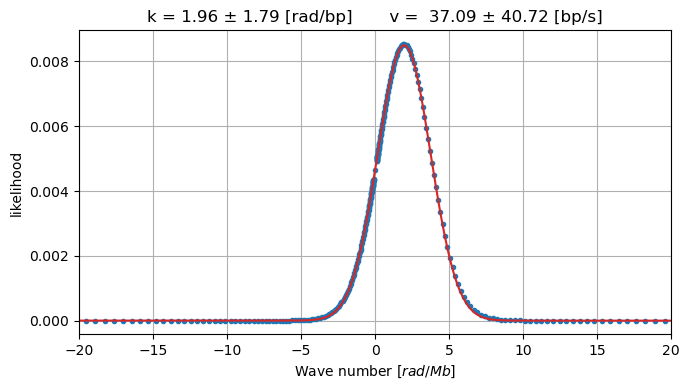

In [119]:

k = -K*1e6
k_mode = k[P_k==P_k.max()][0]


# gaussian fit on P_k
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

popt, pcov = curve_fit(gauss, k, P_k, p0=[P_k.max(),k_mode,1])
perr = np.sqrt(np.diag(pcov))

In [120]:
popt

array([0.00850617, 1.96086209, 1.78608747])

## Publications on transcription rate in mouse
* Bahar Halpern K. et al., Bursty gene expression in the intact mammalian liver. Mol Cell. 2015 Apr 2 58(1):147-56. doi: 10.1016/j.molcel.2015.01.027.
* Mouse Liver polymerase speed: 34 ± 11 bp/s
* "Using intensity ratios of probe libraries targeting both ends of the gene, [investigators] demonstrated that >85% of nascent mRNAs at TSs [transcription sites] are attached to actively transcribing polymerase molecules (Figure S3). Thus, the number of nascent mRNA can be used as a proxy for polymerase occupancy (M). [They] next used polymerase occupancy to infer the transcription rate μ, the average rate of mRNA production from an active TS, using the equation μ=M⋅v/L, where L is the length of the gene and v = 34 ± 11 bp/s is the polymerase speed, which [they] calibrated using actinomycin D treatment (Experimental Procedures)."

* Jonkers I, Kwak H, Lis JT. Genome-wide dynamics of Pol II elongation and its interplay with promoter proximal pausing, chromatin, and exons. Elife. 2014 Apr 29 3: e02407. doi: 10.7554/eLife.02407.
* Mouse liver Pol II Elongation rate: 1.8 - 14.4 bp/sec
* "[Researchers] measured elongation rates ranging from 0.5 to 4 kb/min at ~1000 genes and within different regions of genes. Strikingly, Pol II accelerates as it transcribes through the gene body, and a large amount of variation in elongation rates occurs between genes, and is associated with chromatin and exon density."

986


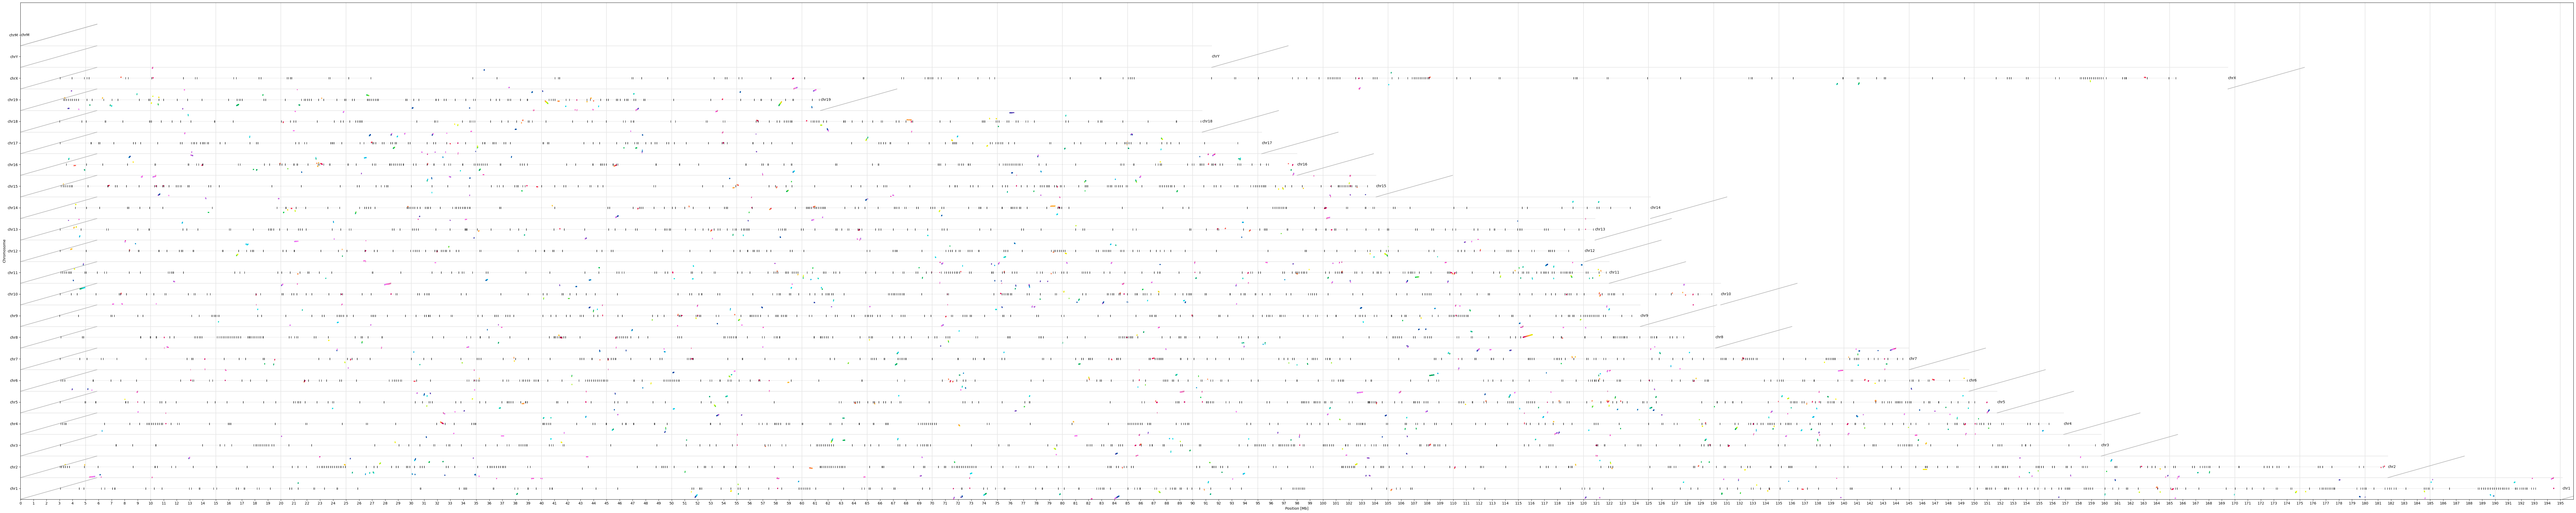

In [25]:
# Thresholds
th = {}
th['adjR2_kf'] = 0.3
th['log10 Length'] = np.log10(1e4)
th['log10 mean_count_per_bp'] = -2
th['log10 pval'] = -1

idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

df_top = df.loc[idx_top,:]
idx_reverse = (df_top.strand == -1).index
df_top.loc[idx_reverse,'speed_max'] *= -1

TAD = pd.read_csv('../resources/TAD/TADMap_scaffold_mm39.bed',sep='\t',header=None)
TAD.columns=['chr','start','end']

# get chromosomes length
chr_size = pd.read_csv('../resources/genome/GRCm39/mm39.chrom.sizes',sep='\t',header=None,index_col=0)
chr_size.columns = ['length']
max_len_Mb = np.ceil(chr_size.length.max()*1e-6).astype(int)

CHR = np.array( [f'chr{c+1}' for c in range(19)] + ['chrX','chrY','chrM'] )

X = np.array([])
Y = np.array([])
C = np.zeros((0,3))
hf =  h5py.File(infile_kalman_on_genes, 'r')

for g, gene in enumerate( df_top.index ):
    chr = np.where(df_top.loc[gene,'chr'] == CHR)[0]
    x = hf[gene]['positions'][:]
    y = np.ones(len(x))*2*chr

    μ_tT = hf[gene]['mu'][:].T
    μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]
    #μ_tT -= μ_genome
    φ_kf = -np.arctan2(np.imag(μ_tT),np.real(μ_tT))
    φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi

    h = φ_kf/(2*np.pi)
    c = p2lc(φ_kf)
    if np.isnan(c).sum() > 0:
        print(gene)

    strand = df.at[gene,'strand']

    X = np.concatenate([X,x])
    Y = np.concatenate([Y,y+strand*h],axis=0)
    C = np.concatenate([C,c],axis=0)

hf.close()


fig, ax = plt.subplots(1,1,figsize=(100,20))

# add x grid every 5 Mb
for i in range(0,max_len_Mb,5):
    ax.plot([i,i],[-1,2*len(CHR)+1],'-',color=[.9,.9,.9])

# plot chromosomes borders
for i,chr in enumerate(CHR):
    ax.plot([0,chr_size.loc[chr,'length']*1e-6],[2*i+1,2*i+1],'-',color=[.9,.9,.9])
    # plot typical expected speed of two rounds at the beginning and of each chromosome
    speed = 34 # bp/sec
    round = 34*3600*24/1e6 # Mb
    ax.plot([0,2*round],[2*i-1,2*i+1],'-',color=[.7,.7,.7])
    ax.plot([chr_size.loc[chr,'length']*1e-6,chr_size.loc[chr,'length']*1e-6 + 2*round],[2*i-1,2*i+1],'-',color=[.7,.7,.7])
    # add chromosome name at the end
    ax.text(chr_size.loc[chr,'length']*1e-6,2*i,chr,fontsize=10,ha='left',va='center')

# plot tads
for i in range(TAD.shape[0]):
    chr = np.where(TAD.at[i,'chr'] == CHR)[0]
    ax.plot([TAD.at[i,'start']*1e-6,TAD.at[i,'end']*1e-6],[2*chr,2*chr],'k-',linewidth=.1,marker='|')

# plot genes
ax.scatter(x=X*1e-6,y=Y,c=C,s=10,marker='|',alpha=1)

ax.set_yticks(range(0,2*len(CHR),2),CHR)
ax.set_xticks(range(0,max_len_Mb))
ax.set_ylabel('Chromosome')
ax.set_xlabel('Position [Mb]')
ax.set_xlim(0,max_len_Mb)
ax.set_ylim(-1,2*len(CHR)+1)

# flip axis
#ax.invert_yaxis()
fig.tight_layout()
fig.savefig('fig/kalman/Phase_position_top_genes.pdf',bbox_inches='tight')





    

# Plot per gene

2860
Wwox


/tmp/ipykernel_42502/3517006502.py:35: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sig2_res = np.nanvar(X - x_hat,0)
/tmp/ipykernel_42502/3517006502.py:36: RuntimeWarning: Degrees of freedom <= 0 for slice.
  sig2_tot = np.nanvar(X,0)


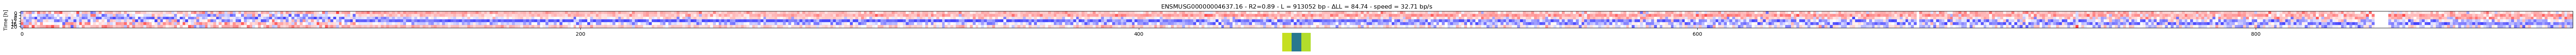

In [76]:
th = {}
th['adjR2_kf'] = 0.1
th['log10 Length'] = 4
th['log10 mean_count_per_bp'] = -1
th['log10 pval'] = -1

idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 Length'] >= th['log10 Length']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

idx_top = df.loc[df.gene_name == 'Wwox',:].index

with h5py.File(infile_kalman_on_genes, 'r') as hf:

    for g, gene in enumerate( idx_top ):
        
        
        gene_name = df.at[gene,'gene_name']
        print(gene_name)
        outfig = f'fig/kalman/top_genes/{gene_name}.pdf'

        X = hf[gene]['measurements'][:]
        n_bin = X.shape[1]
        
        # Amp and phase of fourier transform
        f_n = np.sum(X * np.exp(-1j*ω*T[:,None]),0)
        #f_n -= μ_genome
        a_n = 4/m * np.abs(f_n)
        φ_n = -np.arctan2(np.imag(f_n),np.real(f_n))
        φ_n[φ_n<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
        mu_n = 1/n_bin * np.sum(X,0)
        color_f = p2lc(φ_n)

        # compute fit's R2 and p-value
        x_hat = mu_n[None,:] + 0.5 * a_n[None,:] * np.cos(ω*T[:,None] - φ_n[None,:])
        sig2_res = np.nanvar(X - x_hat,0)
        sig2_tot = np.nanvar(X,0)
        R2 = np.zeros(sig2_res.shape)
        R2[sig2_tot==0] = 0
        R2[np.isnan(sig2_tot)] = 0
        R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
        R2[R2<0] = 0

        # Kalman filter
        μ_tT = hf[gene]['mu'][:].T
        Σ_tT = hf[gene]['Sigma'][:]

        # Amp and phase of kalman filter
        μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]
        #μ_tT -= μ_genome
        a_kf = 4/m * np.abs(μ_tT)
        φ_kf = -np.arctan2(np.imag(μ_tT),np.real(μ_tT))
        φ_kf[φ_kf<0] += 2*np.pi # make sure φ_n is between 0 and 2pi
        color_kf = p2lc(φ_kf)

        # plot phase per bin
        Φ = np.ones((2,n_bin,3))
        Φ[0,:] = color_f
        Φ[1,:] = color_kf
        
        fig, axes = plt.subplots(2,1,figsize=(n_bin/10,15/10))
        ax = axes[0]

        # plot heatmap
        # normalize X columns as Z-score
        X = X[:6,:] + X[6:,:]
        X = (X - X.mean(0))/X.std(0)
        #X = np.concatenate([X[3:,:],X,X[:3,:]],axis=0)
        ax.set_title(rf'{gene} - R2={df.at[gene,"R2"]:.2f} - L = {10**(df.at[gene,"log10 Length"]):.0f} bp - $\Delta$LL = {df.at[gene,"LL_ratio"]:.2f} - speed = {df.at[gene,"speed_max"]:.2f} bp/s')

        ax.imshow(X,aspect='equal',interpolation='none',cmap='bwr',vmin=-3,vmax=3)
        ax.set_yticks(range(6),['0','4','8','12','16','20'])
        ax.set_ylabel('Time [h]')

        fig.savefig(f'fig/kalman/top_genes/{gene}_heatmap.pdf',bbox_inches='tight')


        #fig, ax = plt.subplots(1,1,figsize=(n_bin,3))
        ax = axes[1]
        
        plt.axis('off')
        
        ax.imshow(color_kf,aspect='equal',interpolation='none')
        #for i,c in enumerate(color_f):
        #    cir = plt.Circle((i, 1), R2[i]/2, color=c,fill=True)
        #    ax.add_patch(cir)
            
        ax.set_aspect('equal', adjustable='datalim')
        ax.set_ylim([-0.5,1.5])
        
        ax.set_xlabel('Position rel. to tss [kb]')

        fig.savefig(outfig)

        #plt.close('all')
    


# Plot flanks expression and phase relative to gene body

In [78]:

def get_total_counts_in_window(coord):

    # get coordinates and time points
    T = np.arange(0,48,4)
    strand_dict = {'+': 'forward', '-': 'reverse'}
    [chr,start,end,strand] = coord.split(':')
    start = int(start)
    end = int(end)

    X = np.zeros((1,len(T)))
    for j,t in enumerate(T):

        sample = f'CT{t:02d}'
        fin = bw.open(f"../results/norm_coverage/{sample}/NormCoverage_3p_{strand_dict[strand]}.bw")
        vals = fin.intervals(chr,start,end)
        # get summed count for each time point
        if not vals is None:
            X[0,j] = sum([vals[i][2] for i in range(len(vals))])
    
    # get mean expression per bp
    count_per_bp = X.sum(axis=1)/(end-start)

    # log transform, add pseudo counts and average gene expression across bins
    X = np.log2(X + 1)

    # Get amp phase: fourier transform
    ω = 2*np.pi/P
    phi_n, a_n, R2, pval, mu_n = fourier_transform(X,T,ω)

    return X, count_per_bp, phi_n, a_n, R2, pval, mu_n


# Thresholds
# Thresholds
th = {}
th['adjR2_kf'] = 0.25
th['log10 Length'] = np.log10(2e4)
th['log10 mean_count_per_bp'] = -1
th['log10 pval'] = -2


idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 Length'] > th['log10 Length']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])

print(idx_top.sum())

# get genes relative expression along its body
infile_kalman_on_genes = '../results/kalman/Gene_Q_1e-5/Kalman_Smoothing_1000bp_bu_101_k_bins.hdf5'
hf = h5py.File(infile_kalman_on_genes, 'r')
n_bins_flank = 100
bin_size = 100

Flank_rel_expression = {}
Flank_rel_phase = {}
for strand in ['same','opp']:
    for pos in ['up','start','end','down']:
        flank = f'{strand}_{pos}'
        Flank_rel_expression[flank] = np.zeros((sum(idx_top),n_bins_flank))*np.nan
        Flank_rel_phase[flank] = np.zeros((sum(idx_top),n_bins_flank))*np.nan

def get_flank_expression_phase(gene):

    # get gene coordinates
    chr = gene_phase_amp.at[gene,'chr']
    start = gene_phase_amp.at[gene,'start']
    end = gene_phase_amp.at[gene,'end']
    strand = gene_phase_amp.at[gene,'strand']
    # get the opposite strand ( - if strand is + and + if strand is -)
    strand_opp = ['-' if strand == '+' else '+'][0]

    # get gene mean expression
    X = get_data(f'{chr}:{start}:{end}:{strand}', bw_folder, bin_size)
    μ = X.values.mean()

    # get gene phase, amplitude and mean expression
    with h5py.File(infile_kalman_on_genes, 'r') as hf:
        μ_tT = hf[gene]['mu'][:].T
    μ_tT = μ_tT[0,:] + 1j*μ_tT[1,:]
    φ_start = -np.arctan2(np.imag(μ_tT[0]),np.real(μ_tT[0]))
    if φ_start<0:
        φ_start += 2*np.pi # make sure φ_n is between 0 and 2pi
    φ_end = -np.arctan2(np.imag(μ_tT[-1]),np.real(μ_tT[-1]))
    if φ_end<0:
        φ_end += 2*np.pi # make sure φ_n is between 0 and 2pi


    coord_start = f'{chr}:{start}:{start+2000}:{strand}'
    X_start, count_per_bp_start, φ_start, a_start, R2_start, pval_start, mu_start = get_total_counts_in_window(coord_start)
    coord_end = f'{chr}:{end-2000}:{end}:{strand}'
    X_end, count_per_bp_end, φ_end, a_end, R2_end, pval_end, mu_end = get_total_counts_in_window(coord_end)


    flank_size = n_bins_flank*bin_size
    Flanks = {}
    Flanks['same_up']    = get_data(f'{chr}:{start-flank_size}:{start}:{strand}', bw_folder, bin_size)
    Flanks['same_start'] = get_data(f'{chr}:{start}:{start+flank_size}:{strand}', bw_folder, bin_size)
    Flanks['same_end']   = get_data(f'{chr}:{end-flank_size}:{end}:{strand}', bw_folder, bin_size)
    Flanks['same_down']  = get_data(f'{chr}:{end}:{end+flank_size+1}:{strand}', bw_folder, bin_size)
    Flanks['opp_up'] =    get_data(f'{chr}:{start-flank_size}:{start}:{strand_opp}', bw_folder, bin_size)
    Flanks['opp_start'] = get_data(f'{chr}:{start}:{start+flank_size}:{strand_opp}', bw_folder, bin_size)
    Flanks['opp_end'] =   get_data(f'{chr}:{end-flank_size}:{end}:{strand_opp}', bw_folder, bin_size)
    Flanks['opp_down'] =  get_data(f'{chr}:{end}:{end+flank_size}:{strand_opp}', bw_folder, bin_size)

    # make sure that the retrieved matrix have n_bins_flank+1 bins
    for flank in Flanks:
        if Flanks[flank].shape[0] != n_bins_flank:
            if flank.split('_')[1] in ['up','start']:
                Flanks[flank] = Flanks[flank].iloc[1:,:]
            if flank.split('_')[1] in ['end','down']:
                Flanks[flank] = Flanks[flank].iloc[:-1,:]
    
    if strand == '-':
        # flip flanks
        Flanks['same_up'], Flanks['same_start'], Flanks['same_end'],  Flanks['same_down'] = Flanks['same_down'], Flanks['same_end'], Flanks['same_start'], Flanks['same_up']
        Flanks['opp_up'], Flanks['opp_start'], Flanks['opp_end'],  Flanks['opp_down'] = Flanks['opp_down'], Flanks['opp_end'], Flanks['opp_start'], Flanks['opp_up']
    
        # invert index order
        for flank in Flanks:
            Flanks[flank].sort_index(inplace=True,ascending=False)

    # get flanks phase
    f_flanks = {}
    φ_flanks = {}
    μ_flanks = {}
    for flank in Flanks:
        if flank in ['same_up','opp_up','same_start','opp_start']:
            φ = φ_start
        elif flank in ['same_down','opp_down','same_end','opp_end']:
            φ = φ_end
            
        idx_out = Flanks[flank].var(1) < 1e-10

        f_flanks[flank] = np.sum( Flanks[flank].values * np.exp(-1j*ω*T) ,1)
        f_flanks[flank][idx_out] = np.nan
        
        φ_flanks[flank] = -np.arctan2(np.imag(f_flanks[flank]),np.real(f_flanks[flank]))
        φ_flanks[flank][φ_flanks[flank]<0] += 2*np.pi
        # relative to gene phase
        φ_flanks[flank] = φ_flanks[flank] - φ
        φ_flanks[flank] = (φ_flanks[flank] + np.pi) % (2*np.pi) - np.pi
        φ_flanks[flank][idx_out] = np.nan

        μ_flanks[flank] = (Flanks[flank].values.mean(1) - μ)/np.log(2)
    
    return μ_flanks, φ_flanks

with Pool(24) as p:
    OUT = p.map(get_flank_expression_phase, Genes[idx_top])


for g,gene in enumerate(Genes[idx_top]):
    for flank in Flank_rel_expression:
        Flank_rel_expression[flank][g,:] = OUT[g][0][flank]
        Flank_rel_phase[flank][g,:] = OUT[g][1][flank]


719


/tmp/ipykernel_19736/572027532.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,missing],axis=0)
/tmp/ipykernel_19736/572027532.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,missing],axis=0)
/tmp/ipykernel_19736/572027532.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the 

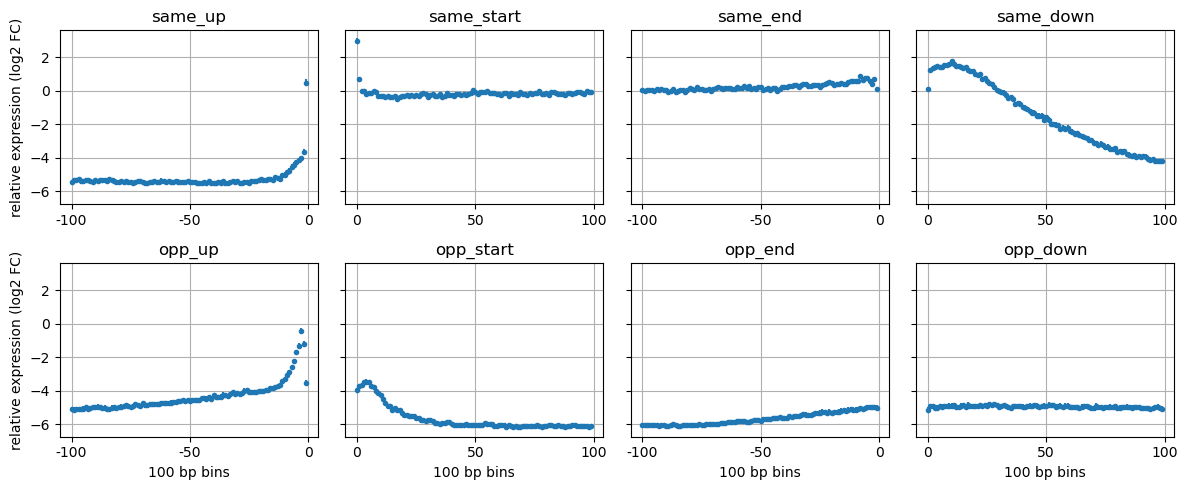

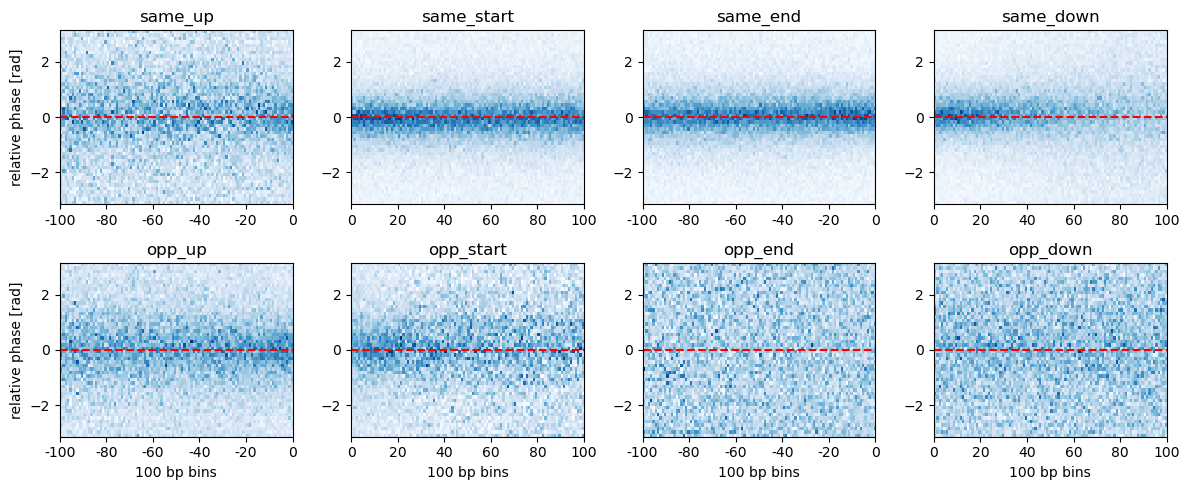

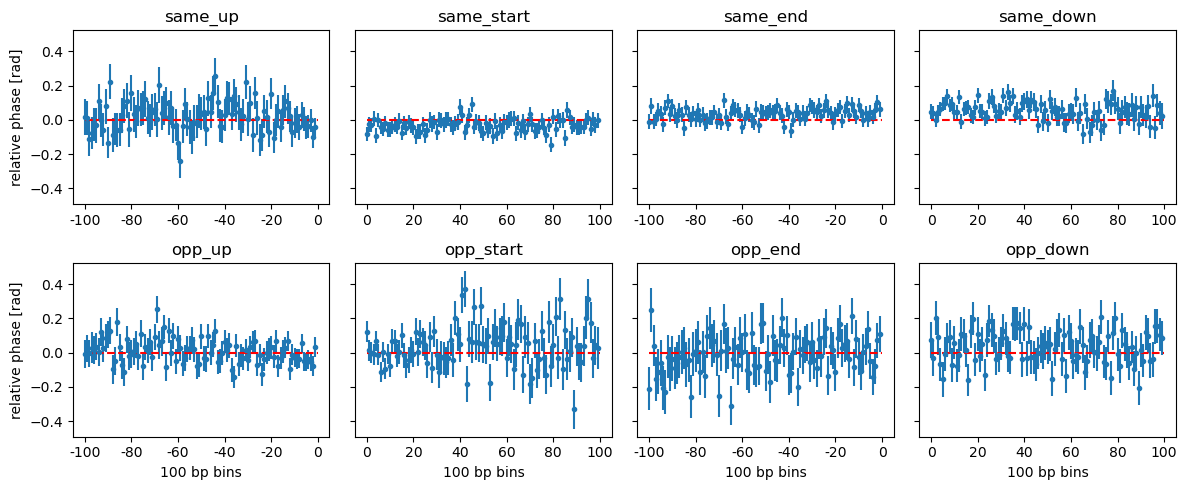

In [79]:
# plot phase and amplitude of flanks
fig, axes = plt.subplots(2, 4, figsize=(12, 5),sharey=True)
axes = axes.flatten()
for i, flank in enumerate(Flank_rel_expression):
    ax = axes[i]
    ax.errorbar(x=range(n_bins_flank),y=Flank_rel_expression[flank].mean(0),yerr=Flank_rel_expression[flank].std(0)/np.sqrt(sum(idx_top)),fmt='.')
    ax.set_title(flank)
    if flank.split('_')[0] == 'opp':
        ax.set_xlabel(f'{bin_size} bp bins')
    # if up put xtick from -bins to 0
    if flank.split('_')[1]  in ['up','end']:
        ax.set_xticks(range(0,n_bins_flank+1,50),range(-n_bins_flank,1,50))
    else:
        ax.set_xticks(range(0,n_bins_flank+1,50),range(0,n_bins_flank+1,50))
    if flank.split('_')[1] == 'up':
        ax.set_ylabel('relative expression (log2 FC)')
    ax.grid()
    
fig.tight_layout()
fig.savefig('fig/kalman/Flank_expression.pdf',bbox_inches='tight')

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
for i, flank in enumerate(Flank_rel_phase):
    ax = axes[i]
    bins = np.linspace(-np.pi,np.pi,51)

    H = np.zeros((len(bins)-1,n_bins_flank))
    for b in range(n_bins_flank):
        H[:,b] = np.histogram(Flank_rel_phase[flank][:,b],bins=bins)[0]

    H /= H.sum(0,keepdims=True)

    bins_center = (bins[:-1] + bins[1:])/2
    mu = np.sum(bins_center[:,None] * H,0)

    #H = np.log2(H)
    ax.imshow(H,aspect='auto',interpolation='none',extent=[0,n_bins_flank,bins[0],bins[-1]],cmap='Blues',origin='lower')
    ax.plot([0,n_bins_flank],[0,0],'r--')
    #ax.scatter(range(n_bins_flank),mu,marker='.',color='g')
    ax.set_title(flank)
    if flank.split('_')[0] == 'opp':
        ax.set_xlabel(f'{bin_size} bp bins')
    # if up put xtick from -bins to 0
    if flank.split('_')[1] in ['up','end']:
        ax.set_xticks(range(0,n_bins_flank+1,20),range(-n_bins_flank,1,20))
    else:
        ax.set_xticks(range(0,n_bins_flank+1,20),range(0,n_bins_flank+1,20))
    if flank.split('_')[1] == 'up':
        ax.set_ylabel('relative phase [rad]')

fig.tight_layout()
fig.savefig('fig/kalman/Flank_phase.pdf',bbox_inches='tight')


fig, axes = plt.subplots(2, 4, figsize=(12, 5),sharey=True)
axes = axes.flatten()
for i, flank in enumerate(Flank_rel_phase):
    ax = axes[i]

    
    mu = np.nanmean( Flank_rel_phase[flank],0)
    std = np.nanstd( Flank_rel_phase[flank],0)/np.sqrt(np.sum( ~np.isnan(Flank_rel_phase[flank]), 0 ))

    #H = np.log2(H)
    ax.errorbar(range(n_bins_flank),mu,std,fmt='.')
    ax.plot([0,n_bins_flank],[0,0],'r--')
    ax.set_title(flank)
    if flank.split('_')[0] == 'opp':
        ax.set_xlabel(f'{bin_size} bp bins')
    # if up put xtick from -bins to 0
    if flank.split('_')[1] in ['up','end']:

        ax.set_xticks(range(0,n_bins_flank+1,20),range(-n_bins_flank,1,20))
    else:
        ax.set_xticks(range(0,n_bins_flank+1,20),range(0,n_bins_flank+1,20))
    if flank.split('_')[1] == 'up':
        ax.set_ylabel('relative phase [rad]')

fig.tight_layout()
fig.savefig('fig/kalman/Flank_phase_mean_std.pdf',bbox_inches='tight')

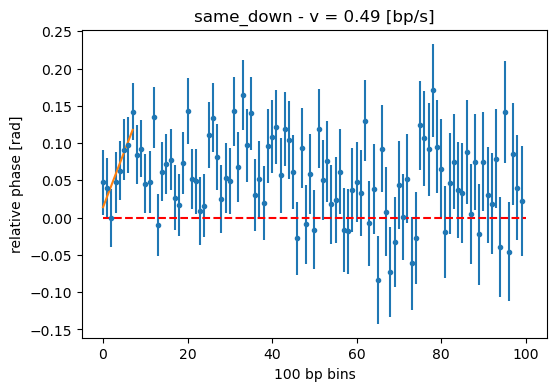

In [80]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))

flank = 'same_down'

mu = np.nanmean( Flank_rel_phase[flank],0)
std = np.nanstd( Flank_rel_phase[flank],0)/np.sqrt(np.sum( ~np.isnan(Flank_rel_phase[flank]), 0 ))

# linear regression on the first 10 points
n_fit = 8
p = np.polyfit(range(n_fit),mu[:n_fit],1)

slope = p[0] # rad/bin
k = slope/bin_size # rad/bp
v = (ω/3600)/k # bp/s
#H = np.log2(H)
ax.errorbar(range(n_bins_flank),mu,std,fmt='.')
ax.plot([0,n_bins_flank],[0,0],'r--')
ax.plot(range(n_fit),np.polyval(p,range(n_fit)),'-',color='tab:orange')
ax.set_title(flank + f' - v = {v:.2f} [bp/s]')
ax.set_xlabel(f'{bin_size} bp bins')
# if up put xtick from -bins to 0

ax.set_xticks(range(0,n_bins_flank+1,20),range(0,n_bins_flank+1,20))
ax.set_ylabel('relative phase [rad]')

fig.savefig('fig/kalman/Flank_phase_mean_std_fit.pdf',bbox_inches='tight')


In [44]:
p

array([0.01026023, 0.03918064])

# Plot phase color scale

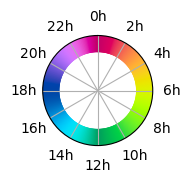

In [55]:
n = 512
φ = np.linspace(0,2*np.pi,n)
r = np.ones(n)

color = p2lc(φ)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=color,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()
fig.savefig('fig/kalman/Phase_color_wheel.pdf',bbox_inches='tight',dpi=300)
fig.savefig('fig/kalman/Phase_color_wheel.png',bbox_inches='tight',dpi=300)

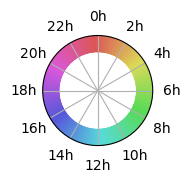

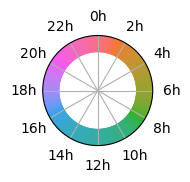

In [14]:
import seaborn as sns

n = 512
φ = np.linspace(0,2*np.pi,n)
r = np.ones(n)

# plot hsv colors in polar coordinates
h = φ/(2*np.pi)
s = r/r.max()
v = np.ones(n)

colors = sns.color_palette('hls',n_colors=512)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=colors,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()

colors = sns.color_palette('husl',n_colors=512)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='polar')
for shift in np.arange(0,0.4,0.02):
    ax.scatter(x=φ,y=r+shift,c=colors,s=.2,marker='o',rasterized=True)
#ax.scatter(x=φ,y=r,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.1,c=color,s=10*r,marker='o',alpha=1)
#ax.scatter(x=φ,y=r-.2,c=color,s=10*r,marker='o',alpha=1)
ax.grid('off')
ax.yaxis.set_visible(False)

ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])

# ---- mod here ---- #
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
# ---- mod here ---- #

fig.tight_layout()

Text(0, 0.5, 'p-value')

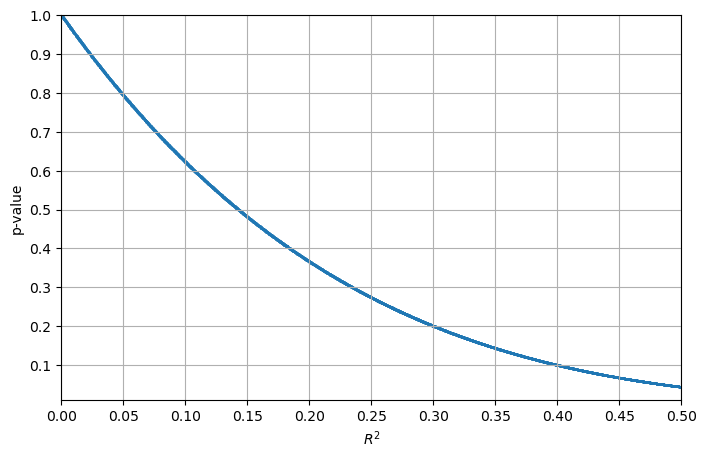

In [67]:
fix, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(gene_phase_amp.R2,gene_phase_amp.pval,s=1,marker='.')
#ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,.05))
ax.set_yticks(np.arange(0,1.1,.1))
ax.set_xlim([0,.5])
ax.set_ylim([1e-2,1])
ax.grid()

ax.set_xlabel(r'$R^2$')
ax.set_ylabel(r'p-value')

# Plot for one gene

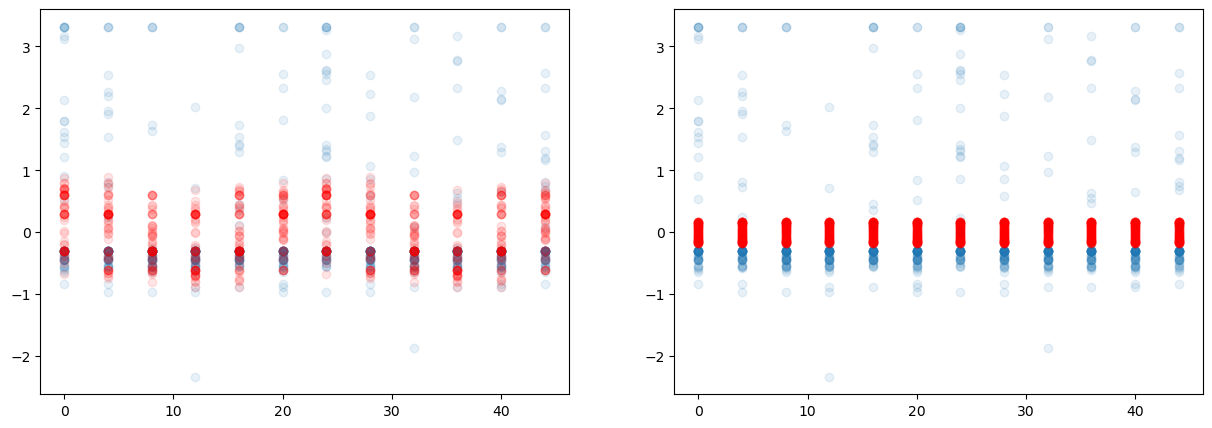

In [196]:
my_gene = 'Ccdc150'
bin_size = 1000

file_gene_phase = '../results/phase_amp/gene_phase_amp.csv'
gene_phase_amp = pd.read_csv(file_gene_phase,index_col=-1,sep='\t')
my_gene_id = gene_phase_amp[gene_phase_amp.gene_name==my_gene].index[0]
infile_kalman_on_genes = f'../results/kalman/Gene_Q_1e-3/Kalman_Smoothing_{bin_size}bp.hdf5'
hf =  h5py.File(infile_kalman_on_genes, 'r')

X = hf[my_gene_id]['measurements'][:] # time x pos
n_bin = X.shape[1]

# Fourier transform on each mesurments seperately
T = np.arange(0,48,4)
ω = 2*np.pi/24
φ, a, R2, pval, μ = fourier_transform(X.T,T,ω)

X_fourier = 0.5 * a[None,:] * np.cos(ω * T[:,None] - φ[None,:])


X_smoothed = hf[my_gene_id]['smoothed'][:]

fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes[0]
ax.scatter(np.repeat(T[:,None],n_bin,axis=1),X,alpha=0.1)
ax.plot(np.repeat(T[:,None],n_bin,axis=1),X_fourier,'ro',alpha=0.1)

ax = axes[1]
ax.scatter(np.repeat(T[:,None],n_bin,axis=1),X,alpha=0.1)
ax.plot(np.repeat(T[:,None],n_bin,axis=1),X_smoothed,'ro',alpha=0.1)

In [165]:
df

chr      start        end  strand     phase  \
gene_id                                                                
ENSMUSG00000000049.12  chr11  108234180  108305222       1  0.300014   
ENSMUSG00000000056.8   chr11  121128079  121146682       1  1.731537   
ENSMUSG00000000078.8   chr13    5911481    5920393       1  0.614279   
ENSMUSG00000000085.17   chr4  120262478  120387383       1  0.068280   
ENSMUSG00000000120.7   chr11   95459644   95478561      -1  5.831859   
...                      ...        ...        ...     ...       ...   
ENSMUSG00000120166.1    chr5  104719508  104732487       1  6.067015   
ENSMUSG00000121513.1   chr14   10227722   10916220      -1  0.988700   
ENSMUSG00000121582.1    chr4  137486016  137493737      -1  3.374477   
ENSMUSG00000121583.1   chr15   76527595   76544261      -1  1.028881   
ENSMUSG00000121597.1    chr5  110071544  110157884       1  4.463688   

                       amplitude        R2  log10 pval  mean_log_expression  \
gene_id                                                                       
ENSMUSG00000000049.12   1.121988  0.747693   -2.691318            15.398472   
ENSMUSG00000000056.8    1.175549  0.718810   -2.479501            13.942038   
ENSMUSG00000000078.8    0.591782  0.748008   -2.693759            12.595303   
ENSMUSG00000000085.17   0.504132  0.788256   -3.033849            13.846190   
ENSMUSG00000000120.7    1.504205  0.850630   -3.715815            10.020072   
...                          ...       ...         ...                  ...   
ENSMUSG00000120166.1    0.774398  0.726651   -2.534773            10.407356   
ENSMUSG00000121513.1    0.339103  0.809178   -3.237175            17.037254   
ENSMUSG00000121582.1    1.913083  0.936400   -5.384429            10.918145   
ENSMUSG00000121583.1    0.383534  0.842619   -3.613714            13.686854   
ENSMUSG00000121597.1    0.642077  0.768682   -2.861060            10.907493   

                       log10 mean_count_per_bp           gene_name  \
gene_id                                                              
ENSMUSG00000000049.12                 0.883569                Apoh   
ENSMUSG00000000056.8                  1.033192                Narf   
ENSMUSG00000000078.8                  0.926901                Klf6   
ENSMUSG00000000085.17                 0.154788               Scmh1   
ENSMUSG00000000120.7                 -0.146666                Ngfr   
...                                        ...                 ...   
ENSMUSG00000120166.1                  0.109396              Zfp33b   
ENSMUSG00000121513.1                  0.371854  ENSMUSG00000121513   
ENSMUSG00000121582.1                  0.530167  ENSMUSG00000121582   
ENSMUSG00000121583.1                  0.979736     Tmem276-zftraf1   
ENSMUSG00000121597.1                 -0.566651  ENSMUSG00000121597   

                       log10 Length     K_max  speed_max  lambda_max_kb  \
gene_id                                                                   
ENSMUSG00000000049.12      4.851515 -0.000022   3.235246    -279.525269   
ENSMUSG00000000056.8       4.269583 -0.000006  11.288101    -975.291956   
ENSMUSG00000000078.8       3.949975 -0.000018   3.984369    -344.249514   
ENSMUSG00000000085.17      5.096580 -0.000004  16.536746   -1428.774820   
ENSMUSG00000000120.7       4.276852  0.000011  -6.706412     579.434018   
...                             ...       ...        ...            ...   
ENSMUSG00000120166.1       4.113241 -0.000047   1.560718    -134.846028   
ENSMUSG00000121513.1       5.837903 -0.000001  53.828572   -4650.788630   
ENSMUSG00000121582.1       3.887674 -0.000011   6.706412    -579.434018   
ENSMUSG00000121583.1       4.221831 -0.000020   3.717139    -321.160838   
ENSMUSG00000121597.1       4.936212 -0.000012   6.256616    -540.571612   

                       LL_ratio        LL_max   adjR2_f  adjR2_kf     adjR2  
gene_id                                                                      
ENSMUSG0000000004

# Length - speed

Text(0, 0.5, '$|v_{max}|~[bp/s]$')

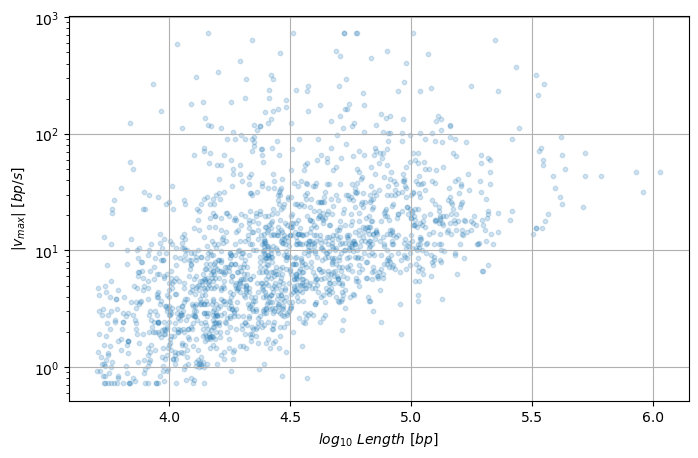

In [152]:
th = {}
th['adjR2_kf'] = 0.2
th['log10 mean_count_per_bp'] = -2
th['log10 pval'] = -1

idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 mean_count_per_bp'] >= th['log10 mean_count_per_bp']) & (df['log10 pval'] <= th['log10 pval'])

df_top = df.loc[idx_top,:]

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(df_top['log10 Length'],np.abs(df_top['speed_max']),s=10,alpha=.2)
ax.set_yscale('log')
ax.grid()

ax.set_xlabel(r'$log_{10}~Length~[bp]$')
ax.set_ylabel(r'$|v_{max}|~[bp/s]$')

# Speed - expression


1370


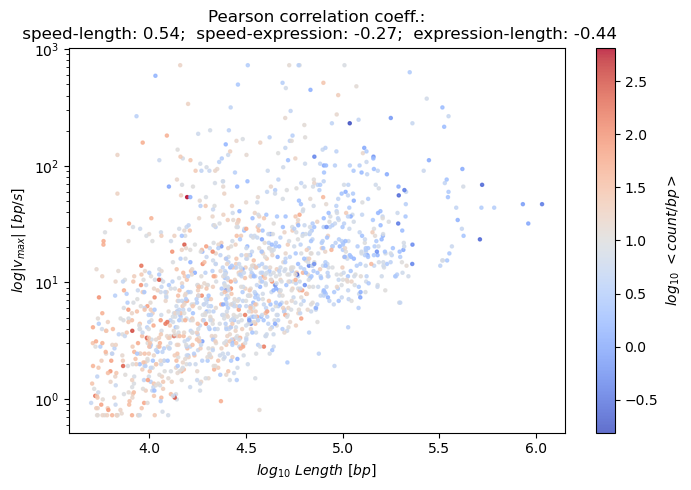

In [186]:
th = {}
th['adjR2_kf'] = 0.2
th['log10 pval'] = -2
idx_top = (df['adjR2_kf'] >= th['adjR2_kf']) & (df['log10 pval'] <= th['log10 pval'])
print(idx_top.sum())

df_top = df.loc[idx_top,:]
df_top = df_top.loc[~np.isinf(df_top.speed_max),:]

x = df_top.loc[:,['log10 mean_count_per_bp','log10 Length','speed_max']].values
x[:,2] = np.log(np.abs(x[:,2]))

rho = np.corrcoef(x.T)



fig, ax = plt.subplots(1,1,figsize=(8,5))

h = ax.scatter(df_top['log10 Length'],np.abs(df_top['speed_max']),s=5,c=df_top['log10 mean_count_per_bp'],alpha=.8,cmap='coolwarm')
# add colorbar
cbar = plt.colorbar(h)
cbar.set_label(r'$log_{10}~<count/bp>$')
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10}~Length~[bp]$')
ax.set_ylabel(r'$log |v_{max}|~[bp/s]$')
ax.set_title(f'Pearson correlation coeff.:\n speed-length: {rho[2,1]:.2f};  speed-expression: {rho[2,0]:.2f};  expression-length: {rho[0,1]:.2f}')

fig.savefig('fig/kalman/speed_length_expression.pdf',bbox_inches='tight')


In [157]:
rho

array([[ 1.        , -0.43712531, -0.28142441],
       [-0.43712531,  1.        ,  0.52900099],
       [-0.28142441,  0.52900099,  1.        ]])

In [52]:
x[:,1] = np.abs(x[:,1])

In [65]:
np.isinf( df.loc[:,'speed_max'] ).sum()

17

# EOF

In [58]:
gene_phase_amp['Length'] = gene_phase_amp.end - gene_phase_amp.start
gene_phase_amp.sort_values('Length',ascending=False,inplace=True)
gene_phase_amp.head(20)

chr      start        end strand     phase  \
gene_id                                                               
ENSMUSG00000030849.19   chr7  129764181  132725079      -  0.570752   
ENSMUSG00000028399.19   chr4   75859475   78130198      -  2.356760   
ENSMUSG00000045103.20   chrX   81992476   84249747      +  3.559357   
ENSMUSG00000039419.18   chr6   45036291   47281147      +  5.637047   
ENSMUSG00000061080.12  chr16   39804723   42002042      +  1.328887   
ENSMUSG00000049252.18   chr2   40485258   42543636      -  1.741243   
ENSMUSG00000068205.15   chr2  140237229  142234886      +  5.304902   
ENSMUSG00000052572.20   chr7   90125880   92098455      +  3.036978   
ENSMUSG00000060924.16   chr8   15942537   17585602      -  0.587465   
ENSMUSG00000066392.13  chr12   88689646   90301709      +  0.499023   
ENSMUSG00000060579.14  chr14   11307738   12919681      +  1.304420   
ENSMUSG00000060843.12  chr10   63265877   64839446      +  0.242741   
ENSMUSG00000052613.17  chr10   72935174   74485569      +  0.522520   
ENSMUSG00000008658.17  chr16    5703219    7229390      +  4.246208   
ENSMUSG00000036815.18   chr1  123249200  124773776      -  0.274247   
ENSMUSG00000021699.18  chr13  108586482  110089995      +  0.541176   
ENSMUSG00000040003.19   chr5   19432034   20909790      +  6.115563   
ENSMUSG00000071424.11   chr6   63232860   64681307      +  5.352217   
ENSMUSG00000022112.15  chr14  115329647  116762591      +  0.770091   
ENSMUSG00000102805.6    chr3   84403733   85794825      -  6.150060   

                       amplitude        R2          pval  mean_log_expression  \
gene_id                                                                         
ENSMUSG00000030849.19   0.403933  0.949898  1.410436e-06            18.227350   
ENSMUSG00000028399.19   0.102517  0.187275  3.933203e-01            17.911005   
ENSMUSG00000045103.20   0.482396  0.534659  3.198668e-02            14.692750   
ENSMUSG00000039419.18   1.166885  0.196142  3.743760e-01             5.140276   
ENSMUSG00000061080.12   0.273915  0.325790  1.696596e-01            11.624323   
ENSMUSG00000049252.18   0.635412  0.163791  4.471129e-01             6.285244   
ENSMUSG00000068205.15   0.170222  0.313665  1.838281e-01            12.223543   
ENSMUSG00000052572.20   1.361846  0.764034  1.506004e-03             9.921358   
ENSMUSG00000060924.16   1.189134  0.718706  3.320633e-03             8.777350   
ENSMUSG00000066392.13   1.641588  0.917266  1.347620e-05            11.587387   
ENSMUSG00000060579.14   0.681083  0.681423  5.813881e-03            14.367804   
ENSMUSG00000060843.12   0.648575  0.537037  3.125770e-02             8.757784   
ENSMUSG00000052613.17   0.582058  0.486786  4.969865e-02             9.470883   
ENSMUSG00000008658.17   0.242051  0.123701  5.519944e-01             9.839560   
ENSMUSG00000036815.18   1.747420  0.469527  5.767483e-02             5.983380   
ENSMUSG00000021699.18   0.920860  0.750102  1.949531e-03            15.651731   
ENSMUSG00000040003.19   0.412761  0.530233  3.337896e-02            10.437055   
ENSMUSG00000071424.11   1.259965  0.228414  3.113356e-01             4.712301   
ENSMUSG00000022112.15   2.579860  0.560347  2.477397e-02             7.088937   
ENSMUSG00000102805.6    0.727167  0.959476  5.428824e-07            16.236605   

                       mean_count_per_bp gene_name   Length  
gene_id                                                      
ENSMUSG00000030849.19           1.250194     Fgfr2  2960898  
ENSMUSG00000028399.19           1.304667     Ptprd  2270723  
ENSMUSG00000045103.20           0.142649       Dmd  2257271  
ENSMUSG00000039419.18           0.000220   Cntnap2  2244856  
ENSMUSG00000061080.12           0.017352     Lsamp  2197319  
ENSMUSG00000049252.18           0.000482     Lrp1b  2058378  
ENSMUSG00000068205.15           0.028803   Macrod2  1997657  
ENSMUSG00000052572.20           0.006340      Dlg2  1972575  
ENSMUSG00000060924.16           0.003386     Csmd1  1643065